In [3]:
import math
import random

In [4]:
class Value:
    def __init__(self, data, label='', _op='', _children=()):
        self.data = data
        self._op = _op
        self._prev = set(_children)
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
        
    def __repr__(self) :
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data + other.data, _op='+', _children=(self, other))
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        if not isinstance(other, Value):
            other = Value(other)
        out = Value(self.data * other.data, _op='*', _children=(self, other))
        def _backward():
            print("mul grad")
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other) :
        return self*other
    
    def tanh(self):
        out = Value(math.tanh(self.data), _children=(self, ), _op='tanh')
        def _backward():
            self.grad += 1 - (out.data**2)
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), _children=(self, ), _op='exp')
        def _backward():
            self.grad += out.data
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        rev_topo = list(reversed(topo))
        for node in rev_topo:
            node._backward()

In [5]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [6]:
a = Value(.5, 'a')
b = Value(1.0, 'c')
c = a + b; c.label = 'c'
d = Value(0.2, 'd')
L = c * d; L.label = "L"
#Ltan = L.tanh(); Ltan.label="ltan"
Lexp = L.exp(); Lexp.label="Lexp"
Lexp.backward()

mul grad


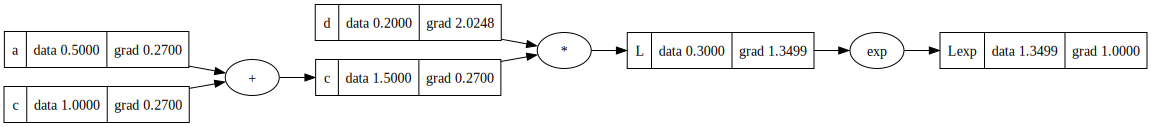

In [7]:
draw_dot(Lexp)

## Single neuron

In [90]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1) for _ in range(nin))]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
        #w*x +b
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
        return out
    
    def parameters(self):
        return (self.w + [self.b])

## Layer of Neurons

In [91]:
class Layer:
    def __init__(self, ninp, nout):
        self.neurons = [Neuron(ninp) for i in range(nout)]
    
    
    def __call__(self, X):
        outs = [n(X) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
            return [p for neuron in self.neurons for p in neuron.parameters()]
            

## Multi-layer perceptron

In [92]:
class MLP:
    def __init__(self, ninp = 3):
        self.layers=[]
        self.layer1 = Layer(ninp, 3)
        self.layers.append(self.layer1)
        self.layer2 = Layer(3,4)
        self.layers.append(self.layer2)
        self.layer3 = Layer(4, 3)
        self.layers.append(self.layer3)
        self.layer4 = Layer(3, 1)
        self.layers.append(self.layer4)
    
    def __call__(self, X):
        out1 = self.layer1(X)
        out2 = self.layer2(out1)
        out3 = self.layer3(out2)
        out4 = self.layer4(out3)
        return out4
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [93]:
X = [2.0 , 3.0, 4.0]

In [94]:
test = Neuron(3)
print(test.parameters())
out = test(X)
draw_dot(out)

[Value(data=<generator object Neuron.__init__.<locals>.<genexpr> at 0x000001FE1B52C120>), Value(data=0.07015050982298177)]


TypeError: unsupported operand type(s) for *: 'generator' and 'float'

In [73]:
test1 = Layer(3, 2)
print(test1.parameters())
print(test1(X))

[0.2439466205053471, 0.9882921436741134, 0.5528668891854895, 0.27556310110956805, 0.7172941242851298, 0.004493298102123955, 0.8006729644159185, -0.14966503372640605]
[Value(data=0.9999861394018633), Value(data=0.9997537506420752)]


In [64]:
mlp = MLP()
print(mlp.parameters())
print(mlp(X))

[0.5129497688887557, 0.9661079281954934, 0.7489115896216736, -0.701169477134943, -0.8783403143865267, -0.9687161273205598, -0.2609668356035426, 0.9981500082046426, -0.658743635529506, -0.896811181142642, 0.8222582638935714, 0.5298003229886679, 0.9231114454871057, -0.9896601261618736, 0.952863848176601, 0.7124144654390452, -0.20910535726202806, -0.9511448506227949, 0.852970782156043, 0.8363763597679235, 0.743045722953122, -0.8406178631976784, 0.9822618875544993, -0.2370953901451971, 0.35354073574156675, -0.9228738371974903, -0.8436317189364739, 0.8632107679333139, -0.9316834788878652, -0.44470031775942886, 0.3401030556143876, -0.776686351702776, -0.4272404554880884, 0.714646843616362, -0.7832133599860873, -0.0639713398486701, -0.7565316016630694, -0.12608767653599262, 0.5633856946884319, 0.15375937588440647, 0.2669963392365726, 0.6473235680667613, 0.4488623823121676, -0.9962933271068728, 0.3943816483097371, -0.21249177919590756, 0.6559142125961015]
Value(data=0.8142182804894362)


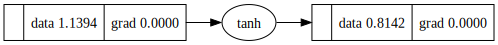

In [65]:
draw_dot(mlp(X))